**Task 1: Basics**

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import json
import numpy as np
from tqdm import tqdm

# ----------------------------
# 1. Device selection
# ----------------------------
# Automatically use GPU if available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------
# 2. Load pretrained model
# ----------------------------
# Load ResNet‑34 pretrained on ImageNet‑1K
resnet34 = torchvision.models.resnet34(weights='IMAGENET1K_V1')
# Set model to evaluation mode (disables dropout, batchnorm updates, etc.)
resnet34.eval()
# Move the model to the selected device (CPU or GPU)
resnet34.to(device)

# ----------------------------
# 3. Prepare label mapping
# ----------------------------
# The JSON file contains entries like "401: some_label"
with open("/kaggle/input/test-data/TestDataSet/labels_list.json", "r") as f:
    labels = json.load(f)
# Extract integer class indices from each "index:label" string
imagenet_indices = [int(entry.split(":")[0]) for entry in labels]
# Now imagenet_indices is a list of the 100 target ImageNet class IDs

# ----------------------------
# 4. Define image transforms
# ----------------------------
# Standard ImageNet normalization values
MEAN = np.array([0.485, 0.456, 0.406])
STD  = np.array([0.229, 0.224, 0.225])

# Compose transforms: convert to tensor and normalize
plain_transforms = transforms.Compose([
    transforms.ToTensor(),                  # Convert PIL image to torch.Tensor in [0,1]
    transforms.Normalize(mean=MEAN, std=STD)  # Normalize each channel
])

# ----------------------------
# 5. Create dataset and loader
# ----------------------------
# ImageFolder will assign integer targets based on subfolder names
dataset = torchvision.datasets.ImageFolder(
    root="/kaggle/input/test-data/TestDataSet",
    transform=plain_transforms
)

# DataLoader for batching and parallel loading
loader = DataLoader(
    dataset,
    batch_size=32,     # Number of images per batch
    shuffle=False,     # No need to shuffle for evaluation
    num_workers=4      # Number of worker processes for data loading
)

# ----------------------------
# 6. Initialize counters
# ----------------------------
top1_correct = 0   # Count of correct top-1 predictions
top5_correct = 0   # Count of correct top-5 predictions
total = 0          # Total number of samples processed

# ----------------------------
# 7. Evaluation loop
# ----------------------------
with torch.no_grad():  # Disable gradient computation for speed and memory
    for images, targets in tqdm(loader, desc="Evaluating batches"):
        # Move images and targets to the correct device
        images  = images.to(device)
        targets = targets.to(device)+401

        # Forward pass: compute logits for all 1000 ImageNet classes
        outputs = resnet34(images)  # Shape: [batch_size, 1000]

        # Restrict to only the 100 classes we're interested in
        # This masks out all other class logits
        # masked_outputs = outputs[:, imagenet_indices]  # Shape: [batch_size, 100]

        # Get the top-5 class indices (within our 100-class subset)
        # top5 contains the indices (0–99) of the highest logits per sample
        # _, top5 = masked_outputs.topk(5, dim=1)  # Shape: [batch_size, 5]
        _, top5 = outputs.topk(5, dim=1)
        
        # The top‑1 prediction is simply the first element in each row
        top1 = top5[:, 0]                        # Shape: [batch_size]

        # Update counters:
        #   top‑1 correct if our best guess equals the true label
        top1_correct += (top1 == targets).sum().item()
        #   top‑5 correct if true label appears anywhere in the top‑5
        top5_correct += sum(targets[i] in top5[i] for i in range(len(targets)))
        # Increase total samples count
        total += targets.size(0)

# ----------------------------
# 8. Compute and print final accuracy
# ----------------------------
top1_acc = top1_correct / total * 100  # Convert to percentage
top5_acc = top5_correct / total * 100  # Convert to percentage

print(f"Total samples evaluated: {total}")
print(f"Top-1 Accuracy: {top1_acc:.2f}%")
print(f"Top-5 Accuracy: {top5_acc:.2f}%")


Using device: cuda


Evaluating batches: 100%|██████████| 16/16 [00:01<00:00, 13.08it/s]

Total samples evaluated: 500
Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


In this first step, we establish a clean performance baseline by evaluating the pre‑trained ResNet‑34 on the provided test subset of ImageNet‑1K. We apply the same normalization (mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) used during ResNet’s original training so that our inputs match the model’s expected distribution. We then compute both Top‑1 and Top‑5 accuracies: Top‑1 measures the fraction of examples for which the model’s most confident class is correct, while Top‑5 allows for more leniency by counting an example as correct if the true label appears among the top five predictions. Reporting both metrics gives us a clear picture of the model’s strict versus relaxed performance, and provides the reference point against which all adversarial attacks will be compared.  

**Task 2: Pixel-wise attacks**

Using device: cuda
Running FGSM attack on dataset...


FGSM: 100%|██████████| 500/500 [00:19<00:00, 25.68it/s]


✔️ FGSM adversarial images generated.

📐 MAX L∞ distance: 0.020000

🔍 Visualizing misclassified samples:


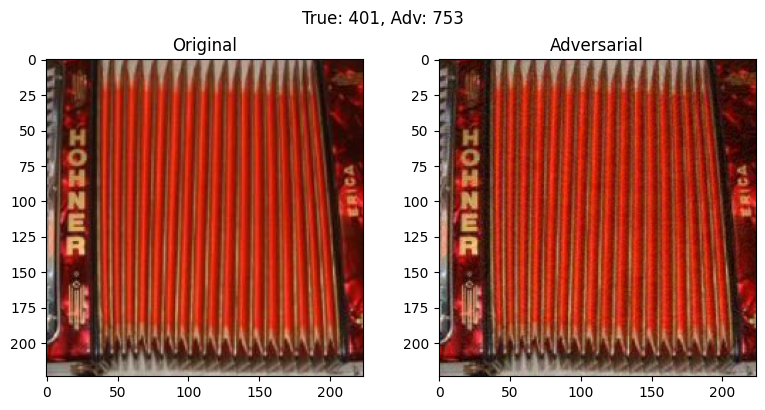

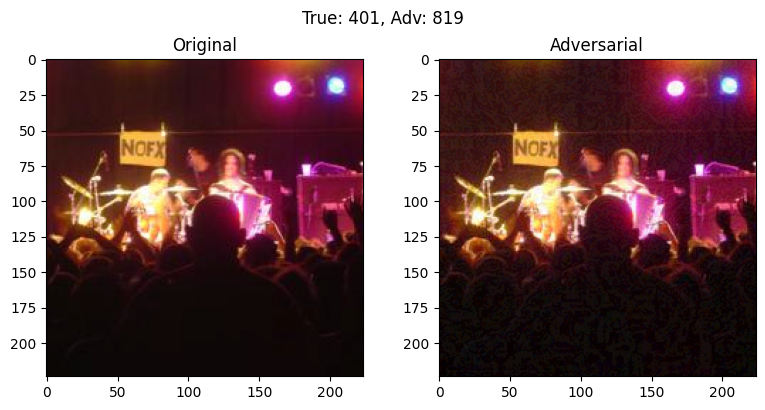

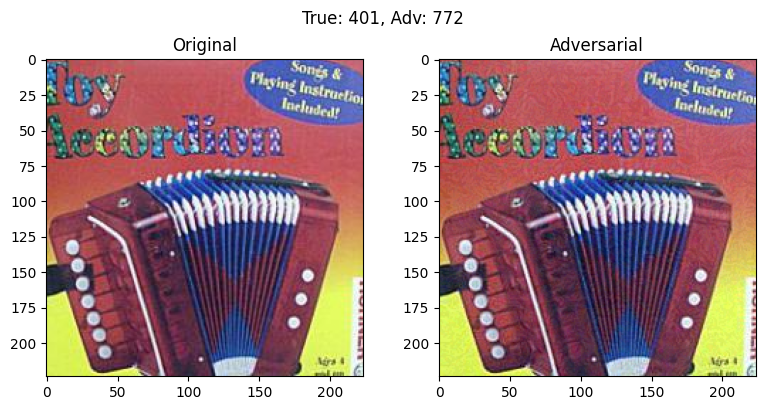

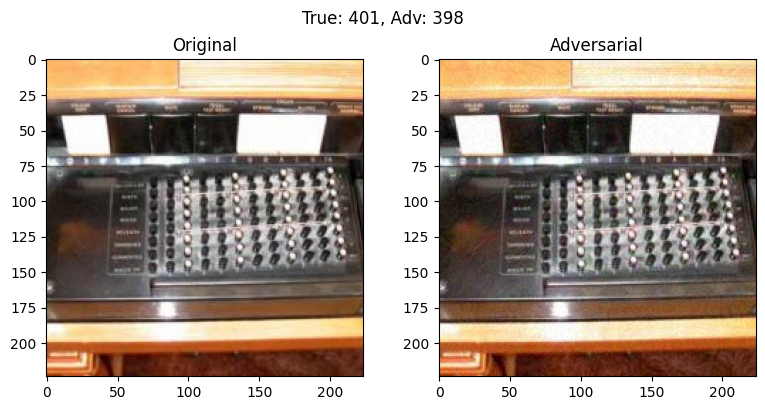

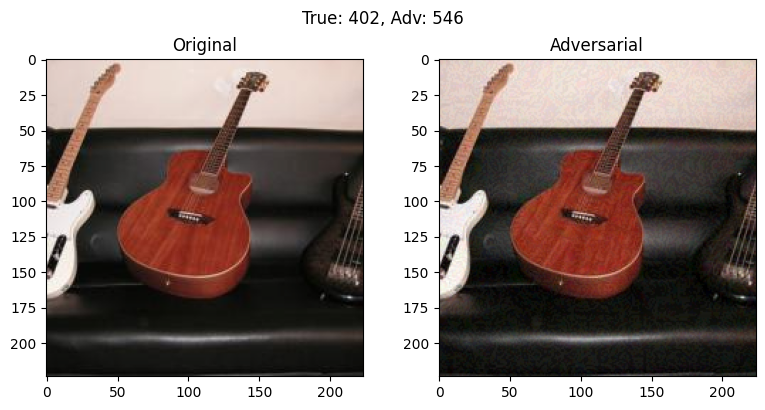


📊 Evaluating adversarial accuracy...

✅ FGSM Evaluation (ε=0.02):
Top-1 Accuracy: 3.40%
Top-5 Accuracy: 21.20%


In [3]:
import os
import json
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# ----------------------------
# 1. Select computation device
# ----------------------------
# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------
# 2. Load pretrained model
# ----------------------------
# ResNet‑34 pretrained on ImageNet‑1K
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
model.eval()              # set to evaluation mode
model.to(device)          # move model to chosen device

# ----------------------------
# 3. Load target class indices
# ----------------------------
with open("/kaggle/input/test-data/TestDataSet/labels_list.json", "r") as f:
    labels = json.load(f)
# Extract integer ImageNet class IDs from strings like "401:label"
imagenet_indices = [int(x.split(":")[0]) for x in labels]

# ----------------------------
# 4. Define transforms
# ----------------------------
# Normalization parameters for ImageNet
MEAN = np.array([0.485, 0.456, 0.406])
STD  = np.array([0.229, 0.224, 0.225])
normalize   = transforms.Normalize(mean=MEAN, std=STD)
# To undo normalization for visualization
unnormalize = transforms.Normalize(mean=-MEAN/STD, std=1/STD)
# Convert PIL image to tensor in [0,1]
to_tensor   = transforms.ToTensor()

# ----------------------------
# 5. FGSM attack parameter
# ----------------------------
EPSILON = 0.02  # perturbation magnitude in [0,1] pixel space

# ----------------------------
# 6. Prepare dataset
# ----------------------------
root = "/kaggle/input/test-data/TestDataSet"
# ImageFolder without transforms so we get raw PIL images
dataset = torchvision.datasets.ImageFolder(root=root)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

# ----------------------------
# 7. Output directories & logs
# ----------------------------
adv_save_dir = "Adversarial_Test_Set_1"
os.makedirs(adv_save_dir, exist_ok=True)

adv_images = []     # store normalized adversarial tensors
orig_images = []    # store normalized original tensors
true_labels  = []   # store true class indices
adv_labels   = []   # store adversarial predictions
linf_distances = [] # store ∞-norm distances per image

print("Running FGSM attack on dataset...")

# ----------------------------
# 8. Generate adversarial examples
# ----------------------------
for i, (img_pil, label) in enumerate(tqdm(dataset, desc="FGSM")):
    # 8.1 Convert to tensor and move to device
    raw = to_tensor(img_pil).unsqueeze(0).to(device)  # shape [1,3,H,W]
    raw.requires_grad_(True)                          # enable gradient
    label=label+401
    # 8.2 Normalize before feeding to model
    normed = normalize(raw)

    # 8.3 Forward pass and mask to our 100 classes
    logits = model(normed)
    # masked = logits[:, imagenet_indices]

    # 8.4 Compute loss w.r.t. true label
    target_tensor = torch.tensor([label], device=device)
    loss = torch.nn.functional.cross_entropy(logits, target_tensor)

    # 8.5 Backpropagate to get gradient of input
    model.zero_grad()
    loss.backward()

    # 8.6 Create adversarial image by taking a step in sign of gradient
    sign_grad = raw.grad.sign()
    adv_raw = raw + EPSILON * sign_grad
    adv_raw = torch.clamp(adv_raw, 0, 1)  # keep pixels in [0,1]

    # 8.7 Normalize adversarial image
    adv_norm = normalize(adv_raw)

    # 8.8 Save adversarial image to disk
    save_path = os.path.join(adv_save_dir, f"adv_{i:04d}.png")
    save_image(adv_raw.squeeze().cpu(), save_path)

    # 8.9 Record for evaluation
    with torch.no_grad():
        pred_logits = model(adv_norm)
        # pred_masked = pred_logits[:, imagenet_indices]
        pred_top1 = pred_logits.argmax(dim=1).item()

    orig_images.append(normed.cpu())
    adv_images.append(adv_norm.cpu())
    true_labels.append(label)
    adv_labels.append(pred_top1)

    # 8.10 Compute L∞ distance between raw and adversarial
    linf = torch.max(torch.abs(adv_raw - raw)).item()
    linf_distances.append(linf)

print("✔️ FGSM adversarial images generated.")

# ----------------------------
# 9. Summary of perturbations
# ----------------------------
max_linf = max(linf_distances)
print(f"\n📐 MAX L∞ distance: {max_linf:.6f}")

# ----------------------------
# 10. Visualize some misclassifications
# ----------------------------
print("\n🔍 Visualizing misclassified samples:")
orig_images = torch.cat(orig_images)
adv_images  = torch.cat(adv_images)
true_labels = torch.tensor(true_labels)
adv_labels  = torch.tensor(adv_labels)

mis_idx = (adv_labels != true_labels).nonzero(as_tuple=True)[0]
for idx in mis_idx[:5]:
    # Undo normalization for display
    orig_img = unnormalize(orig_images[idx]).permute(1,2,0).detach().numpy().clip(0,1)
    adv_img  = unnormalize(adv_images[idx]).permute(1,2,0).detach().numpy().clip(0,1)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
    ax1.imshow(orig_img); ax1.set_title("Original")
    ax2.imshow(adv_img);  ax2.set_title("Adversarial")
    fig.suptitle(f"True: {true_labels[idx].item()}, Adv: {adv_labels[idx].item()}")
    plt.tight_layout()
    plt.show()

# ----------------------------
# 11. Evaluate on adversarial set
# ----------------------------
print("\n📊 Evaluating adversarial accuracy...")
top1_corr = top5_corr = total = 0

model.eval()
with torch.no_grad():
    for start in range(0, len(adv_images), 32):
        batch = adv_images[start:start+32].to(device)
        targets = true_labels[start:start+32].to(device)

        outputs = model(batch)
        # masked_out = outputs[:, imagenet_indices] # Commented this since, professor wants model to predict out of 1000 classes

        _, top5 = outputs.topk(5, dim=1)
        top1   = top5[:,0]

        top1_corr += (top1 == targets).sum().item()
        top5_corr += sum(targets[j].item() in top5[j] for j in range(len(targets)))
        total += targets.size(0)

adv_top1_acc = top1_corr / total * 100
adv_top5_acc = top5_corr / total * 100

print(f"\n✅ FGSM Evaluation (ε={EPSILON}):")
print(f"Top-1 Accuracy: {adv_top1_acc:.2f}%")
print(f"Top-5 Accuracy: {adv_top5_acc:.2f}%")

We craft adversarial examples using the Fast Gradient Sign Method (FGSM), which perturbs every pixel by at most ε in the direction that maximally increases the model’s loss. We compute the gradient of the cross‑entropy loss with respect to the input image, take its sign, and scale it by ε (here set to 0.02 in normalized pixel space). This single‑step attack is computationally efficient yet often sufficient to induce large drops in accuracy. After adding the perturbation and clipping the result to valid pixel ranges, we re‑evaluate Top‑1 and Top‑5 accuracies. It is observed that the top-1 accuracy drops to just 3.40% while the top-5 accuracy drops to 21.20%, showing dramatic drops of 72.0% and 73.0% respectively. The top-5 accuracy is slightly more robust to perturbations compared to the top-1 accuracy.


**Task 3: Improved attacks**

Using device: cuda
Running PGD attack on dataset...


PGD Attack: 100%|██████████| 500/500 [01:20<00:00,  6.19it/s]


✔️ PGD adversarial images generated.

📐 MAX L∞ distance: 0.010000

🔍 Visualizing PGD misclassifications:


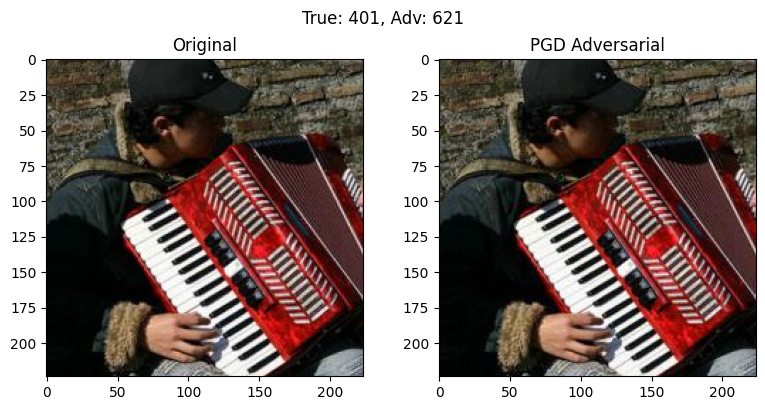

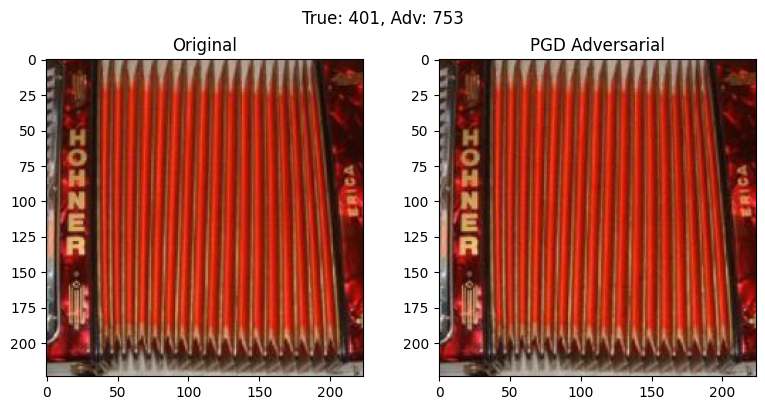

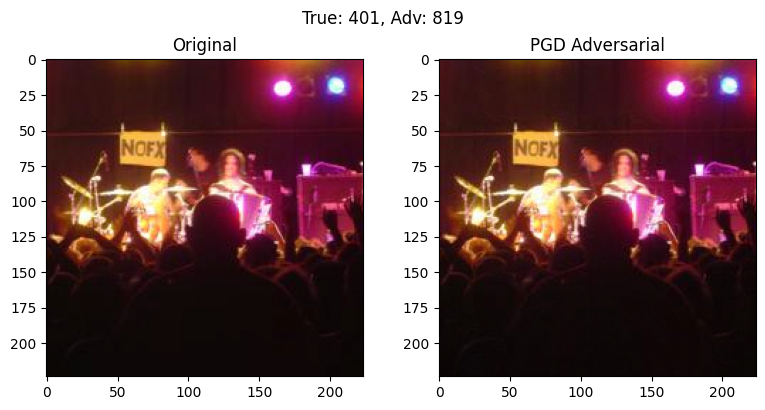

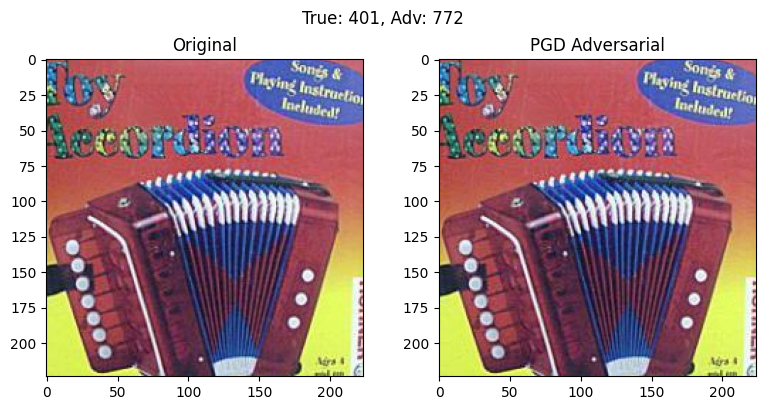

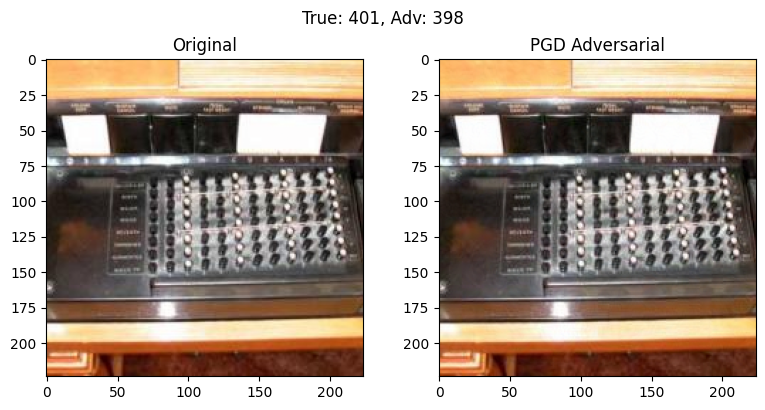


📊 Evaluating accuracy on PGD adversarial set...

✅ PGD Evaluation (ε=0.02, α=0.001, iter=10):
Top-1 Accuracy: 0.00%
Top-5 Accuracy: 4.40%


PGD (10 iters): 100%|██████████| 500/500 [01:09<00:00,  7.15it/s]


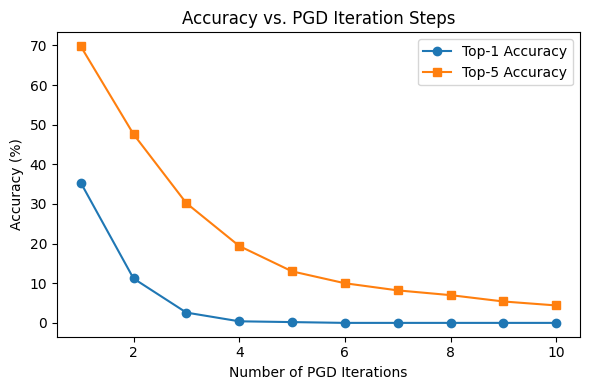

In [6]:
import os
import json
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# ----------------------------
# 1. Select computation device
# ----------------------------
# Use GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------
# 2. Load pretrained model
# ----------------------------
# Load ResNet‑34 pretrained on ImageNet‑1K
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
model.eval()          # set model to evaluation mode (disable dropout, etc.)
model.to(device)      # move model parameters to chosen device

# ----------------------------
# 3. Load target class indices
# ----------------------------
with open("/kaggle/input/test-data/TestDataSet/labels_list.json", "r") as f:
    labels = json.load(f)
# Parse lines like "401: some_label" -> take integer 401
imagenet_indices = [int(x.split(":")[0]) for x in labels]

# ----------------------------
# 4. Define transforms
# ----------------------------
# ImageNet normalization constants
MEAN = np.array([0.485, 0.456, 0.406])
STD  = np.array([0.229, 0.224, 0.225])
normalize   = transforms.Normalize(mean=MEAN, std=STD)
# Inverse normalization for visualization
unnormalize = transforms.Normalize(mean=-MEAN/STD, std=1/STD)
# Convert PIL image to [0,1] tensor
to_tensor   = transforms.ToTensor()

# ----------------------------
# 5. PGD attack hyperparameters
# ----------------------------
EPSILON  = 0.02   # maximum perturbation (∞-norm bound)
ALPHA    = 0.001  # step size per iteration
NUM_ITER = 10    # number of PGD iterations

# ----------------------------
# 6. Prepare dataset
# ----------------------------
root = "/kaggle/input/test-data/TestDataSet"
# Use ImageFolder without transforms to get raw PIL images and labels
dataset = torchvision.datasets.ImageFolder(root=root)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

# ----------------------------
# 7. Create output directory
# ----------------------------
adv_save_dir2 = "Adversarial_Test_Set_2"
os.makedirs(adv_save_dir2, exist_ok=True)

# Lists to store tensors and labels for later evaluation
adv_images_pgd      = []
orig_images_pgd     = []
true_labels_pgd     = []
adv_labels_pgd      = []
linf_distances_pgd  = []

print("Running PGD attack on dataset...")

# ----------------------------
# 8. Generate PGD adversarial examples
# ----------------------------
for i, (img_pil, label) in enumerate(tqdm(dataset, desc="PGD Attack")):
    # 8.1 Convert image to tensor and move to device
    raw = to_tensor(img_pil).unsqueeze(0).to(device)  # shape [1, 3, H, W]
    orig_tensor = raw.clone().detach()                # save original for projection
    label=label+401

    # 8.2 Initialize perturbed image to the original
    perturbed = orig_tensor.clone().detach()
    perturbed.requires_grad_(True)                    # enable gradients

    # 8.3 Iteratively apply small FGSM steps and project back
    for _ in range(NUM_ITER):
        # 8.3.1 Normalize before feeding into the model
        normed = normalize(perturbed)

        # 8.3.2 Forward pass and mask to target classes
        logits = model(normed)
        # masked = logits[:, imagenet_indices]

        # 8.3.3 Compute loss w.r.t. true label
        target_tensor = torch.tensor([label], device=device)
        loss = torch.nn.functional.cross_entropy(logits, target_tensor)

        # 8.3.4 Backpropagate to get gradient of perturbed image
        model.zero_grad()
        loss.backward()

        # 8.3.5 Take a small step in the sign of the gradient (FGSM)
        step = ALPHA * perturbed.grad.sign()
        perturbed_data = perturbed + step

        # 8.3.6 Project perturbation into the ε-ball around the original
        delta = torch.clamp(perturbed_data - orig_tensor,
                            min=-EPSILON, max=EPSILON)
        perturbed = torch.clamp(orig_tensor + delta, 0, 1).detach()
        perturbed.requires_grad_(True)

    # 8.4 After iterations, normalize adversarial example
    adv_norm = normalize(perturbed)

    # 8.5 Save adversarial image to disk (denormalized pixel range)
    save_path = os.path.join(adv_save_dir2, f"adv_{i:04d}.png")
    save_image(perturbed.squeeze().cpu(), save_path)

    # 8.6 Record predictions on the adversarial example
    with torch.no_grad():
        pred_logits = model(adv_norm)
        # pred_masked = pred_logits[:, imagenet_indices]
        pred_top1 = pred_logits.argmax(dim=1).item()

    # 8.7 Store tensors and labels for batch evaluation
    orig_images_pgd.append(normalize(orig_tensor).cpu())
    adv_images_pgd.append(adv_norm.cpu())
    true_labels_pgd.append(label)
    adv_labels_pgd.append(pred_top1)

    # 8.8 Compute L∞ distance between original and adversarial
    linf = torch.max(torch.abs(perturbed - raw)).item()
    linf_distances_pgd.append(linf)

print("✔️ PGD adversarial images generated.")

# ----------------------------
# 9. Summarize perturbation magnitude
# ----------------------------
max_linf = max(linf_distances_pgd)
print(f"\n📐 MAX L∞ distance: {max_linf:.6f}")

# ----------------------------
# 10. Visualize some misclassified examples
# ----------------------------
print("\n🔍 Visualizing PGD misclassifications:")
orig_images_pgd = torch.cat(orig_images_pgd)
adv_images_pgd  = torch.cat(adv_images_pgd)
true_labels_pgd = torch.tensor(true_labels_pgd)
adv_labels_pgd  = torch.tensor(adv_labels_pgd)

mis_idx = (adv_labels_pgd != true_labels_pgd).nonzero(as_tuple=True)[0]
for idx in mis_idx[:5]:
    # Undo normalization for display
    orig_img = unnormalize(orig_images_pgd[idx]).permute(1,2,0).detach().numpy().clip(0,1)
    adv_img  = unnormalize(adv_images_pgd[idx]).permute(1,2,0).detach().numpy().clip(0,1)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
    ax1.imshow(orig_img); ax1.set_title("Original")
    ax2.imshow(adv_img);  ax2.set_title("PGD Adversarial")
    fig.suptitle(f"True: {true_labels_pgd[idx].item()}, Adv: {adv_labels_pgd[idx].item()}")
    plt.tight_layout()
    plt.show()

# ----------------------------
# 11. Evaluate on adversarial set
# ----------------------------
print("\n📊 Evaluating accuracy on PGD adversarial set...")
top1_corr = top5_corr = total = 0

model.eval()
with torch.no_grad():
    for start in range(0, len(adv_images_pgd), 32):
        batch   = adv_images_pgd[start:start+32].to(device)
        targets = true_labels_pgd[start:start+32].to(device)

        outputs = model(batch)
        # masked_out = outputs[:, imagenet_indices]

        _, top5 = outputs.topk(5, dim=1)
        top1   = top5[:,0]

        top1_corr += (top1 == targets).sum().item()
        top5_corr += sum(targets[j].item() in top5[j] for j in range(len(top5)))
        total     += targets.size(0)

adv_top1_acc_pgd = top1_corr / total * 100
adv_top5_acc_pgd = top5_corr / total * 100

print(f"\n✅ PGD Evaluation (ε={EPSILON}, α={ALPHA}, iter={NUM_ITER}):")
print(f"Top-1 Accuracy: {adv_top1_acc_pgd:.2f}%")
print(f"Top-5 Accuracy: {adv_top5_acc_pgd:.2f}%")




# 12. Sweep PGD iteration count and record accuracies
iter_steps    = list(range(1, NUM_ITER+1))
top1_acc_list = []
top5_acc_list = []

for num_steps in iter_steps:
    top1_corr = 0
    top5_corr = 0
    total     = len(dataset)

    # Run PGD for num_steps and immediately evaluate each example
    for img_pil, label in tqdm(dataset, desc=f"PGD ({num_steps} iters)"):
        # prepare
        raw       = to_tensor(img_pil).unsqueeze(0).to(device)
        orig      = raw.detach().clone()
        perturbed = orig.clone().detach().requires_grad_(True)
        label=label+401

        # PGD loop
        for _ in range(num_steps):
            normed = normalize(perturbed)
            logits = model(normed)
            # masked = logits[:, imagenet_indices]
            loss   = torch.nn.functional.cross_entropy(logits, torch.tensor([label], device=device))
            model.zero_grad(); loss.backward()

            step   = ALPHA * perturbed.grad.sign()
            updated= perturbed + step
            delta  = torch.clamp(updated - orig, -EPSILON, EPSILON)
            perturbed = torch.clamp(orig + delta, 0, 1).detach().requires_grad_(True)

        # final prediction
        with torch.no_grad():
            pred=model(normalize(perturbed))
            # masked = pred[:, imagenet_indices]
            _, top5 = pred.topk(5, dim=1)
            pred1 = top5[:,0].item()

        # accumulate
        if pred1 == label:
            top1_corr += 1
        if label in top5[0].tolist():
            top5_corr += 1

    top1_acc_list.append(100 * top1_corr / total)
    top5_acc_list.append(100 * top5_corr / total)

# 13. Plot
plt.figure(figsize=(6,4))
plt.plot(iter_steps, top1_acc_list, marker='o', label="Top‑1 Accuracy")
plt.plot(iter_steps, top5_acc_list, marker='s', label="Top‑5 Accuracy")
plt.xlabel("Number of PGD Iterations")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. PGD Iteration Steps")
plt.legend()
plt.tight_layout()
plt.show()


To achieve a stronger $L_{\infty}$ attack within the maximum perturbation budget ($\epsilon = 0.02$), we implemented Projected Gradient Descent (PGD), which iterates multiple small FGSM steps, while clipping the pixel values after each iteration to ensure it remains within $\epsilon$ of the original pixel value. This multi‑step approach more thoroughly explores the worst‑case region around each input, and finds higher‑impact perturbations than a single FGSM step. After T iterations, we save the final adversarial examples and report their Top‑1 and Top‑5 accuracies. It is observed that the top-1 accuracy drops to 0% and the top-5 accuracy to 4.4%, while remaining within the perturbation budget, showing drops of 76.0% and 89.80% respectively. This illustrates the effectiveness of PGD in finding the optimal worst-case region within the budget.


**Task 4: Patch attacks**

Using device: cuda
🚨 Running Patch-PGD attack on dataset...


Patch-PGD: 100%|██████████| 500/500 [11:16<00:00,  1.35s/it]


✔️ Patch-based PGD adversarial images generated.

📐 MAX L∞ Distance (Patch): 0.480000

🔍 Visualizing Patch-PGD misclassifications:


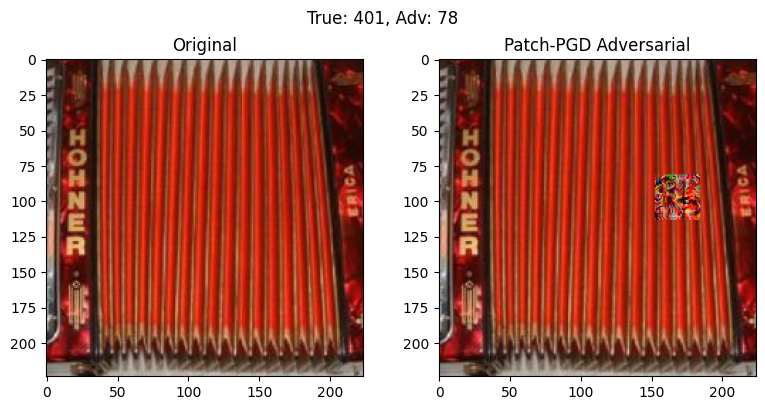

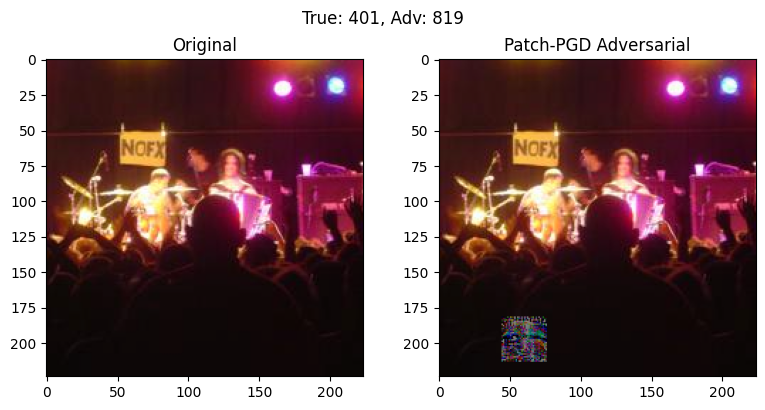

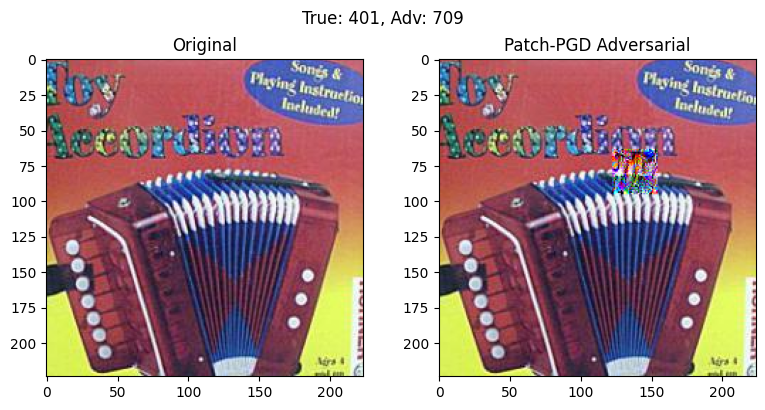

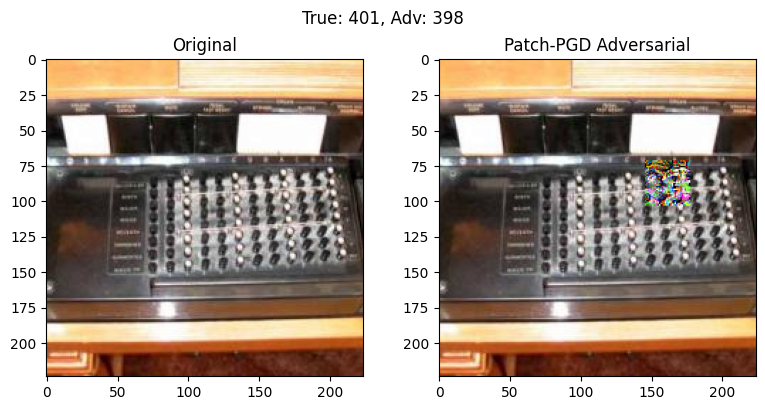

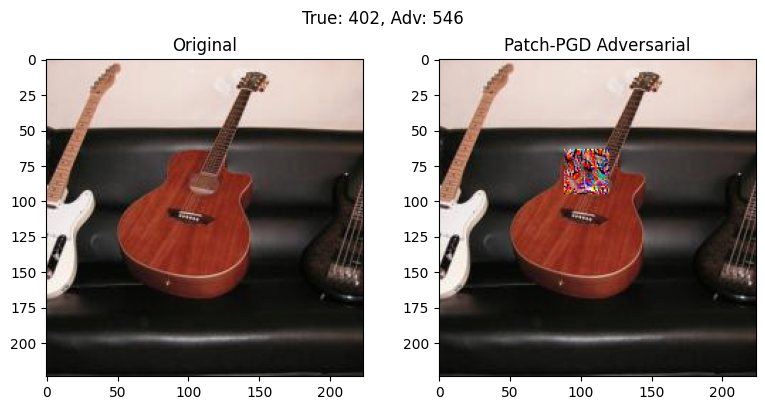


📊 Evaluating accuracy on Patch-based PGD set...

✅ Patch-PGD Evaluation (ε=0.48, patch size=32):
Top-1 Accuracy: 4.00%
Top-5 Accuracy: 42.00%


In [7]:
import os
import json
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# ----------------------------
# 1. Select computation device
# ----------------------------
# Use GPU if available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------
# 2. Load pretrained model
# ----------------------------
# Load ResNet‑34 pretrained on ImageNet‑1K
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
model.eval()          # disable dropout, batchnorm updates, etc.
model.to(device)      # move model to chosen device

# ----------------------------
# 3. Load target class indices
# ----------------------------
with open("/kaggle/input/test-data/TestDataSet/labels_list.json", "r") as f:
    labels = json.load(f)
# Parse entries like "401:label" → integer class IDs
imagenet_indices = [int(x.split(":")[0]) for x in labels]

# ----------------------------
# 4. Define transforms
# ----------------------------
MEAN = np.array([0.485, 0.456, 0.406])
STD  = np.array([0.229, 0.224, 0.225])
# Normalization for model input
normalize   = transforms.Normalize(mean=MEAN, std=STD)
# Inverse normalization for visualization
unnormalize = transforms.Normalize(mean=-MEAN/STD, std=1/STD)
# Convert PIL.Image to [0,1] tensor
to_tensor   = transforms.ToTensor()

# ----------------------------
# 5. PGD attack hyperparameters
# ----------------------------
EPSILON    = 0.48    # max ∞‑norm perturbation for the patch
ALPHA      = 0.05   # step size per iteration
NUM_ITER   = 100    # number of PGD iterations
PATCH_SIZE = 32     # patch is PATCH_SIZE×PATCH_SIZE pixels

# ----------------------------
# 6. Prepare dataset
# ----------------------------
root = "/kaggle/input/test-data/TestDataSet"
# Use ImageFolder without transforms to get raw PIL images and labels
dataset = torchvision.datasets.ImageFolder(root=root)

# ----------------------------
# 7. Prepare output directory
# ----------------------------
adv_save_dir3 = "Adversarial_Test_Set_3"
os.makedirs(adv_save_dir3, exist_ok=True)

# Lists to accumulate results for evaluation
adv_images_patch     = []
orig_images_patch    = []
true_labels_patch    = []
adv_labels_patch     = []
linf_distances_patch = []

print("🚨 Running Patch-PGD attack on dataset...")

# ----------------------------
# 8. Loop over dataset and craft patch-based PGD examples
# ----------------------------
for i, (img_pil, label) in enumerate(tqdm(dataset, desc="Patch-PGD")):
    # 8.1 Convert to tensor, add batch dim, and move to device
    raw = to_tensor(img_pil).unsqueeze(0).to(device)  # shape: [1,3,H,W]
    orig = raw.clone().detach()                       # save original clean image
    label=label+401

    # 8.2 Initialize perturbed image
    perturbed = orig.clone().detach()
    perturbed.requires_grad_(True)

    # 8.3 Randomly choose patch top-left corner
    _, _, H, W = raw.shape
    top  = np.random.randint(0, H - PATCH_SIZE + 1)
    left = np.random.randint(0, W - PATCH_SIZE + 1)

    # 8.4 Perform iterative PGD on the patch
    for _ in range(NUM_ITER):
        # 8.4.1 Normalize current perturbed image
        normed = normalize(perturbed)

        # 8.4.2 Forward pass & mask to our target classes
        logits = model(normed)
        # masked = logits[:, imagenet_indices]

        # 8.4.3 Compute cross‑entropy loss against true label
        target_tensor = torch.tensor([label], device=device)
        loss = torch.nn.functional.cross_entropy(logits, target_tensor)

        # 8.4.4 Backpropagate to get gradient wrt perturbed image
        model.zero_grad()
        loss.backward()

        # 8.4.5 Extract gradient and apply it only inside the patch
        grad = perturbed.grad.data
        patch_grad = torch.zeros_like(grad)
        patch_grad[:, :, top:top+PATCH_SIZE, left:left+PATCH_SIZE] = \
            grad[:, :, top:top+PATCH_SIZE, left:left+PATCH_SIZE]

        # 8.4.6 Take a small step in sign of patch gradient
        updated = perturbed + ALPHA * patch_grad.sign()

        # 8.4.7 Project back into the ε‑ball around the original
        delta = torch.clamp(updated - orig, min=-EPSILON, max=EPSILON)
        perturbed = torch.clamp(orig + delta, 0, 1).detach()
        perturbed.requires_grad_(True)

    # 8.5 Normalize final adversarial image for model input
    adv_norm = normalize(perturbed)

    # 8.6 Save adversarial image (denormalized) to disk
    save_path = os.path.join(adv_save_dir3, f"adv_patch_{i:04d}.png")
    save_image(perturbed.squeeze().cpu(), save_path)

    # 8.7 Record model’s top‑1 prediction on adversarial example
    with torch.no_grad():
        pred_logits = model(adv_norm)
        # pred_masked = pred_logits[:, imagenet_indices]
        pred_top1   = pred_logits.argmax(dim=1).item()

    # 8.8 Store for later batch evaluation
    orig_images_patch.append(normalize(orig).cpu())
    adv_images_patch.append(adv_norm.cpu())
    true_labels_patch.append(label)
    adv_labels_patch.append(pred_top1)

    # 8.9 Compute L∞ distance between clean and perturbed images
    linf = torch.max(torch.abs(perturbed - raw)).item()
    linf_distances_patch.append(linf)

print("✔️ Patch-based PGD adversarial images generated.")

# ----------------------------
# 9. Summarize perturbation magnitude
# ----------------------------
max_linf = max(linf_distances_patch)
print(f"\n📐 MAX L∞ Distance (Patch): {max_linf:.6f}")

# ----------------------------
# 10. Visualize a few misclassified samples
# ----------------------------
print("\n🔍 Visualizing Patch-PGD misclassifications:")
orig_images_patch = torch.cat(orig_images_patch)
adv_images_patch  = torch.cat(adv_images_patch)
true_labels_patch = torch.tensor(true_labels_patch)
adv_labels_patch  = torch.tensor(adv_labels_patch)

mis_idx = (adv_labels_patch != true_labels_patch).nonzero(as_tuple=True)[0]
for idx in mis_idx[:5]:
    # Undo normalization for display
    orig_img = unnormalize(orig_images_patch[idx]).permute(1,2,0).detach().numpy().clip(0,1)
    adv_img  = unnormalize(adv_images_patch[idx]).permute(1,2,0).detach().numpy().clip(0,1)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
    ax1.imshow(orig_img); ax1.set_title("Original")
    ax2.imshow(adv_img);  ax2.set_title("Patch-PGD Adversarial")
    fig.suptitle(f"True: {true_labels_patch[idx].item()}, Adv: {adv_labels_patch[idx].item()}")
    plt.tight_layout()
    plt.show()

# ----------------------------
# 11. Evaluate on the adversarial set
# ----------------------------
print("\n📊 Evaluating accuracy on Patch-based PGD set...")
top1_corr = top5_corr = total = 0

model.eval()
with torch.no_grad():
    for start in range(0, len(adv_images_patch), 32):
        batch   = adv_images_patch[start:start+32].to(device)
        targets = true_labels_patch[start:start+32].to(device)

        outputs   = model(batch)
        # masked_out = outputs[:, imagenet_indices]

        _, top5 = outputs.topk(5, dim=1)
        top1    = top5[:, 0]

        top1_corr += (top1 == targets).sum().item()
        top5_corr += sum(targets[j].item() in top5[j] for j in range(len(top5)))
        total     += targets.size(0)

adv_top1_acc_patch = top1_corr / total * 100
adv_top5_acc_patch = top5_corr / total * 100

print(f"\n✅ Patch-PGD Evaluation (ε={EPSILON}, patch size={PATCH_SIZE}):")
print(f"Top-1 Accuracy: {adv_top1_acc_patch:.2f}%")
print(f"Top-5 Accuracy: {adv_top5_acc_patch:.2f}%")


Patch attacks modify a small region of the image rather than every pixel. To test this scenario, we restrict perturbations to a 32×32 square patch while allowing a larger maximum change ($\epsilon=0.48$) within that region. We choose a random patch location for each image and apply PGD only inside the patch. The rest of the image remains untouched. By evaluating Top‑1 and Top‑5 accuracies on these “patched” adversarial examples, the model’s robustness to localized, high‑magnitude changes is assessed, analogous to a physical sticker or obstruction in the camera’s field of view. It is observed that the top-1 accuracy drops to 4.00%, a drop of 72.00%, and the top-5 accuracy drops to 42.00%, a drop of 52.20%. This shows that patch attacks significantly reduce the top-1 accuracy but do not have such a debilitating impact on the top-5 accuracy, as the perturbations are localized to a small region.


**Task 5: Transferring attacks**


In [9]:
import os
import json
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

# ----------------------------
# 1. Select computation device
# ----------------------------
# Automatically use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------
# 2. Load target class indices
# ----------------------------
# We have a JSON file mapping "index:label" strings → extract integer indices
with open("/kaggle/input/test-data/TestDataSet/labels_list.json", "r") as f:
    labels = json.load(f)
imagenet_indices = [int(l.split(":")[0]) for l in labels]

# ----------------------------
# 3. Load the original dataset label map
# ----------------------------
# We need the original labels (in folder order) to align adversarial sets
original_dataset = torchvision.datasets.ImageFolder(
    root="/kaggle/input/test-data/TestDataSet",
    transform=transforms.ToTensor()
)
# samples is a list of (path, label) → we extract just the labels
original_label_map = [label for _, label in original_dataset.samples]

# ----------------------------
# 4. Define transforms for evaluation
# ----------------------------
mean_norms = [0.485, 0.456, 0.406]  # ImageNet mean
std_norms  = [0.229, 0.224, 0.225]  # ImageNet std
transform = transforms.Compose([
    transforms.ToTensor(),                      # convert PIL→Tensor [0,1]
    transforms.Normalize(mean=mean_norms,       # normalize channels
                         std=std_norms)
])

# ----------------------------
# 5. Custom Dataset for flat PNGs
# ----------------------------
class AdversarialFlatDataset(Dataset):
    def __init__(self, img_dir, label_map, transform=None):
        self.img_dir   = img_dir
        # sort so that ordering matches the original_label_map
        self.img_paths = sorted([f for f in os.listdir(img_dir) if f.endswith(".png")])
        self.transform = transform
        self.label_map = label_map

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # load the iᵗʰ image and its corresponding original label
        img_path = os.path.join(self.img_dir, self.img_paths[idx])
        image    = Image.open(img_path).convert("RGB")
        label    = self.label_map[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# ----------------------------
# 6. Load and prepare the model
# ----------------------------
# We're using DenseNet‑121 here
model = torchvision.models.densenet121(weights='IMAGENET1K_V1')
model.eval()            # disable dropout, BatchNorm updates, etc.
model.to(device)        # move model weights to chosen device

# ----------------------------
# 7. Define our datasets to evaluate
# ----------------------------
dataset_paths = {
    "Original":           "/kaggle/input/test-data/TestDataSet",
    "Adversarial Set 1":  "/kaggle/working/Adversarial_Test_Set_1",
    "Adversarial Set 2":  "/kaggle/working/Adversarial_Test_Set_2",
    "Adversarial Set 3":  "/kaggle/working/Adversarial_Test_Set_3",
}

results = {}

# ----------------------------
# 8. Evaluate each dataset
# ----------------------------
for name, path in dataset_paths.items():
    print(f"\nEvaluating {name}...")

    # Choose appropriate Dataset class
    if "Adversarial" in name:
        # Flat PNGs with original labels
        dataset = AdversarialFlatDataset(path, original_label_map, transform=transform)
    else:
        # The folder structure gives (image, label) pairs directly
        dataset = torchvision.datasets.ImageFolder(root=path, transform=transform)

    # DataLoader for batching
    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

    # Counters for accuracy
    top1_correct = 0
    top5_correct = 0
    total = 0

    # Disable gradients for inference
    with torch.no_grad():
        for images, targets in tqdm(loader, desc=f"  {name} batches"):
            # Move data to the correct device
            images, targets = images.to(device), targets.to(device)+401

            # Forward pass: logits for all 1000 ImageNet classes
            outputs = model(images)
            # Restrict to only our 100 target classes
            # masked_outputs = outputs[:, imagenet_indices]

            # Get top‑5 predictions per sample
            _, top5 = outputs.topk(5, dim=1)
            # Extract the top‑1 prediction
            top1 = top5[:, 0]

            # Update counters
            top1_correct += (top1 == targets).sum().item()
            # Count if true label is in the top‑5
            top5_correct += sum(targets[i] in top5[i] for i in range(len(targets)))
            total += targets.size(0)

    # Compute percentages
    top1_acc = 100 * top1_correct / total
    top5_acc = 100 * top5_correct / total
    results[name] = {"Top-1 Accuracy": round(top1_acc, 2),
                     "Top-5 Accuracy": round(top5_acc, 2)}

# ----------------------------
# 9. Print final summary
# ----------------------------
print("\n📊 Final Transferability Results (DenseNet-121):")
for name, metrics in results.items():
    print(f"  {name}: Top-1 = {metrics['Top-1 Accuracy']}%, "
          f"Top-5 = {metrics['Top-5 Accuracy']}%")


Using device: cuda

Evaluating Original...


  Original batches: 100%|██████████| 16/16 [00:02<00:00,  7.02it/s]



Evaluating Adversarial Set 1...


  Adversarial Set 1 batches: 100%|██████████| 16/16 [00:02<00:00,  6.88it/s]



Evaluating Adversarial Set 2...


  Adversarial Set 2 batches: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]



Evaluating Adversarial Set 3...


  Adversarial Set 3 batches: 100%|██████████| 16/16 [00:02<00:00,  6.80it/s]


📊 Final Transferability Results (DenseNet-121):
  Original: Top-1 = 74.8%, Top-5 = 93.6%
  Adversarial Set 1: Top-1 = 46.0%, Top-5 = 76.2%
  Adversarial Set 2: Top-1 = 54.8%, Top-5 = 86.4%
  Adversarial Set 3: Top-1 = 68.0%, Top-5 = 91.2%


We investigate whether adversarial examples generated against ResNet‑34 also fool DenseNet-121, another popular convolutional neural network (CNN) architecture. 

On Adversarial test-set 1, created using FGSM, the top-1 accuracy drops by 28.8% and the top-5 accuracy drops by 17.4% w.r.t the original dataset, which is a much lesser drop compared to that observed on ResNet-34. This is because FGSM is a white-box adversarial attack which utilizes the model and the dataset to degrade its performance, and perturbations carried out based on one model fail to replicate the same performance degradation on another model.

On Adversarial test-set 2, created using PGD,  the top-1 accuracy drops by 20.0% and the top-5 accuracy drops by 7.2% w.r.t the original dataset. The transferability of this method from one model to another is even worse, as PGD can be regarded as an ultra-optimized variant of FGSM, and hence has extreme "overfitting" (in terms of adversarial attacks) to the original model and dataset. Hence trasnferring the same perturbations to another model result in lesser degradation in performance.

On Adversarial test-set 3, created using patch attacks,  the top-1 accuracy drops by 6.8% and the top-5 accuracy drops by 2.4% w.r.t the original dataset. This is because DenseNet has a densely connected architecture which concatenates feature maps from previous layers, unlike ResNet which uses residual/skip connections. This means that each subsequent layer in DenseNet has a larger receptive field compared to ResNet, which makes it more robust to localized patch-based attacks.